In [49]:
import pandas as pd
import tqdm
import datetime
df = pd.read_csv("./daily/stock_2024-12-24.csv")
cdf = pd.read_csv("stock_today.csv")
fdf = pd.read_csv("./daily/stock_fund_2024-12-25.csv")
df = pd.concat([df,cdf])
df = df.merge(fdf)

def make_record(g,date):
    g = g[g["date"]<date]
    g = g.sort_values(by="date",ascending=False)[:10]
    if g.shape[0]>=10:
        # print(g.shape)
        name = g.iloc[0]["name"]
        last_1day, last_3_days, last_7days = g.iloc[0], g.iloc[1:3], g.iloc[5:]
        last_7day_volume = last_7days.volume.mean()
        last_3day_volume = last_3_days.volume.mean()/last_7day_volume
        last_1day_volume = last_1day.volume/last_7day_volume
        last_3day_change = g.iloc[1].close/g.iloc[3].close
        last_1day_change = g.iloc[0].close/g.iloc[1].close
        last_1day_cc = (last_1day.close/last_1day.open-1)*100
        last_1day_cm = ((last_1day.high-last_1day.close)/g.iloc[1].close)*100
        last_1day_cl = ((last_1day.close-last_1day.low)/g.iloc[1].close)*100
        last_1day_amp = ((last_1day.high-last_1day.low)/g.iloc[1].close)*100
        # print(g.iloc[0].volume,last_7day_volume,g.iloc[0])
        last_3day_change = (last_3day_change-1)*100
        last_1day_change = (last_1day_change-1)*100
        return {"name":name,"last_3day_volume":last_3day_volume,"last_1day_volume":last_1day_volume,
                        "last_3day_change":last_3day_change,"last_1day_change":last_1day_change,"last_1day_cm":last_1day_cm,
                        "last_1day_cc":last_1day_cc,"last_1day_cl":last_1day_cl,"last_1day_amp":last_1day_amp,
                        "main_amount":g.iloc[0]["main_amount"], "main_percent":g.iloc[0]["main_percent"]}

def make_data(df,cdate,flag=True):
    records = []
    for k,g in tqdm.tqdm(df.groupby("code"),desc=f"processing date[{cdate}]"):
        record = make_record(g,cdate)
        if record:
            record["date"]=cdate
            record["code"]=k
            if flag:
                cg,pg = g[g.date==cdate],g[g.date<cdate].sort_values("date",ascending=False)
                if cg.shape[0]>0 and pg.shape[0]>0:
                    change = cg.iloc[0].close/pg.iloc[0].close
                    change = (change-1)*100
                    record["change"]=change
                    records.append(record)
            else:
                records.append(record)
        # break
                
    return pd.DataFrame(records)

lst = []
hdts, cdt =("2024-12-23","2024-12-24","2024-12-25"),"2024-12-26"
for dt in hdts:
    tdf = make_data(df,dt)
    lst.append(tdf)
padf = pd.concat(lst)
cadf = make_data(df,cdt,False)
cadf.head()   
       

processing date[2024-12-26]: 100%|████████████████████████████████████████████████████████████████████████████████████| 4412/4412 [00:10<00:00, 434.63it/s]


,name,last_3day_volume,last_1day_volume,last_3day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,main_amount,main_percent,date,code
0,浦发银行,2.163880,1.567080,5.741127,2.171767,0.394867,2.171767,2.171767,2.566634,-26162868.0,-3.49,2024-12-26,sh600000
1,白云机场,0.831348,0.688453,0.308325,0.102459,0.307377,0.411100,0.819672,1.127049,-1436186.0,-1.32,2024-12-26,sh600004
2,东风股份,0.469863,0.353731,-4.456094,-2.331962,2.331962,-2.331962,1.371742,3.703704,-28439594.0,-11.14,2024-12-26,sh600006
3,中国国贸,0.275160,0.291069,2.432886,0.778051,0.614251,0.736799,1.310401,1.924652,-4089277.0,-5.78,2024-12-26,sh600007
4,首创环保,0.751563,0.568399,1.519757,0.299401,0.299401,0.000000,1.197605,1.497006,-4060236.0,-2.01,2024-12-26,sh600008


<Axes: >

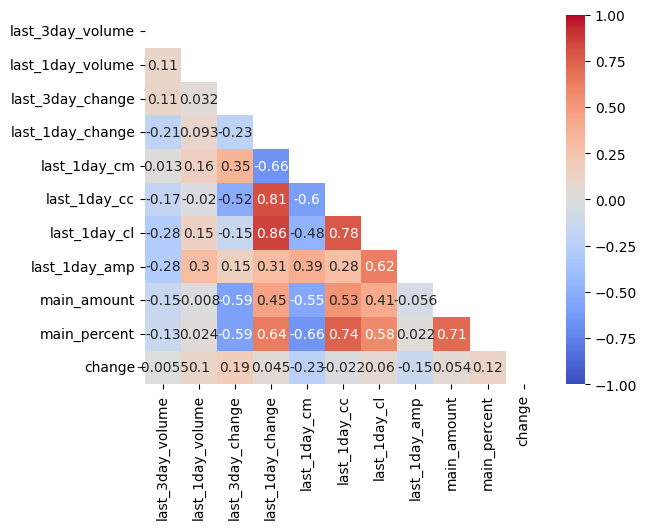

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# pdf = adf[(adf.last_3day_volume>4)&(adf.last_1day_volume>4)][:50].copy()
pdf = padf[(padf.last_3day_volume<1.5)&(padf.last_1day_volume>3)][:50].copy()
pdf.drop(columns=["code","name","date"],inplace=True)
upp_mat = np.triu(pdf.corr())
sns.heatmap(pdf.corr(), vmin=-1, vmax=+1, annot=True, cmap="coolwarm", mask=upp_mat)
# def ascore(v):
#     frac = v.last_1day_volume/v.last_3day_volume
#     return frac*(v.last_1day_cl-v.last_1day_cm)

# adf["score"]=adf.apply(ascore,axis=1)
# adf.sort_values(by="score",ascending=False)[:50]


In [51]:
from sklearn.model_selection import train_test_split
pdf =padf.dropna().copy()
pdf = pdf[pdf["last_1day_amp"]>0.1]
y = pdf.pop("change")
pdf.drop(columns=["code","name","date"],inplace=True)
X = pdf
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,roc_auc_score,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
# Create a pipeline with preprocessor and classifier
model = Pipeline(steps=[ ('regressor', GradientBoostingRegressor())])
param_distributions = {'regressor__n_estimators': [100,],
    'regressor__learning_rate': [0.01, 0.05,],
    'regressor__max_depth': [4, 5],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [2, 4],
    'regressor__subsample': [0.7, 0.8, ]}
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, 
    param_distributions=param_distributions, 
    n_iter=30,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=2, 
    scoring = 'r2',
    random_state=42,
    n_jobs=-1  )
# Fit the RandomizedSearchCV model
random_search.fit(X_train, y_train)
best_gb = random_search.best_estimator_
test_prediction_gb = random_search.predict(X_test)
print(f"MSE is: {mean_squared_error(y_test, test_prediction_gb)}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
MSE is: 9.889514044043947


In [56]:
pdf = cadf.copy()
pdf = pdf[pdf["last_1day_amp"]>0.1]
ctrain = pdf.drop(columns=["code","name","date"])
pdf["pred"] = random_search.predict(ctrain)
pdf[pdf.last_1day_volume>3].sort_values(by="pred",ascending=False)[:15]

,name,last_3day_volume,last_1day_volume,last_3day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,main_amount,main_percent,date,code,pred
2738,信质集团,0.797428,4.468278,-1.722846,5.411585,4.344512,-3.286713,1.905488,6.250000,29290586.0,8.62,2024-12-26,sz002664,3.283523
1127,小方制药,1.356733,3.659308,20.972532,-8.959804,18.656029,-17.006993,0.797791,19.453820,-63915894.0,-8.69,2024-12-26,sh603207,3.009492
3575,筑博设计,1.496745,4.074583,3.797468,-16.829268,19.207317,-18.567164,1.585366,20.792683,-40957738.0,-19.98,2024-12-26,sz300564,2.303676
2423,北新路桥,3.362032,4.724682,20.971867,-7.822410,10.782241,-9.166667,0.211416,10.993658,-86681706.0,-11.78,2024-12-26,sz002307,2.184662
4056,力量钻石,5.631381,3.610522,26.331558,-4.611331,5.164690,-1.200873,0.474308,5.638999,-3346857.0,-0.45,2024-12-26,sz301071,2.144286
2455,柘中股份,1.844824,6.012606,8.663883,-1.536984,5.187320,-4.916512,1.152738,6.340058,921539.0,0.56,2024-12-26,sz002346,1.902144
1068,中材节能,6.933166,3.850021,-0.958904,9.958506,0.000000,9.806630,11.341632,11.341632,122665511.0,33.39,2024-12-26,sh603126,1.884690
2793,电光科技,1.652646,19.484530,20.987654,10.018553,0.000000,0.000000,8.441558,8.441558,-72335613.0,-6.54,2024-12-26,sz002730,1.468343
1083,新亚强,5.854173,7.613654,8.002736,-5.129829,7.979734,-5.129829,1.203293,9.183027,-14477345.0,-5.01,2024-12-26,sh603155,1.347280
3861,卡倍亿,2.623871,3.334376,3.211198,1.535700,6.422018,-3.943396,2.413243,8.835261,35891591.0,4.95,2024-12-26,sz300863,1.202421


[CV] END regressor__learning_rate=0.05, regressor__max_depth=5, regressor__min_samples_leaf=4, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=0.8; total time=  11.1s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=5, regressor__min_samples_leaf=4, regressor__min_samples_split=5, regressor__n_estimators=100, regressor__subsample=0.8; total time=  10.5s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=5, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=0.7; total time=  12.6s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=5, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=0.7; total time=   9.1s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=4, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=0.8; total time=   

In [55]:
pdf[pdf.name=="中材节能"]

,name,last_3day_volume,last_1day_volume,last_3day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,main_amount,main_percent,date,code,pred
1068,中材节能,6.933166,3.850021,-0.958904,9.958506,0.0,9.80663,11.341632,11.341632,122665511.0,33.39,2024-12-26,sh603126,1.88469
